## Cleaning Weekly Scheduled API Data

Importing dependencies

In [1]:
import requests
import pandas as pd
from pprint import pprint
import json
from config import api_key
import time
import numpy as np
from nfl_api_version import get_pbp_stats
from QBs_WRs_season_stats import wr_season_stats
import matplotlib.pyplot as plt

First, we'll create an empty data frame that we can append to later with our desired data

In [2]:
#Create an empty DataFrame to store the API data
weekly_games_df = pd.DataFrame()

We'll create a loop to pull all the necessary urls for our api calls so that our data will include the 17 weeks of the regular season and 4 weeks of post season games

In [3]:
#Create base_url to loop with to pull the season weekly schedule and postseason weekly schedule
base_url = "http://api.sportradar.us/nfl/official/trial/v6/en/games/2020/"
#Empty list to store urls for the .get() request
urls = []
#loop through each week in the season and pull that week's schedule url and append it to the list of urls
for i in range(1,18):
    url = base_url + "REG/"+ str(i) + "/schedule.json?api_key=" + api_key
    urls.append(url)
#loop through each week in the post season and pull that week's schedule url and append it to the list of urls
for i in range(1,5):
    url = base_url + "PST/"+ str(i) + "/schedule.json?api_key=" + api_key
    urls.append(url)

Now we're going to build a function that will pull out our wanted dataa from each api call and append that data into our empty data frame. It is built with try and except statements so that the code will continue running through the api response searching for the next wanted category even if there are instances in which the api response does not contain one specific category.

In [4]:
def grab_base_data(response):
    '''Will take a json response from Sport Radar's Weekly Schedule NFL api 
    and return the game ID, game reference, game number, game schedule, game attendance, 
    game weather, game sr_id, game home team name and alias, game away team and alias, 
    final score and scores at the end of each quarter'''
    #empty lists to temporarily pull data for the response
    ids = []
    references = []
    numbers = []
    scheduled = []
    attendances = []
    weather = []
    sr_ids = []
    home_teams = []
    home_team_alias = []
    home_team_id = []
    away_teams = []
    away_team_alias = []
    away_team_id = []
    home_final = []
    away_final = []
    home_q1 = []
    away_q1 = []
    home_q2 = []
    away_q2 = []
    home_q3 = []
    away_q3 = []
    home_q4 = []
    away_q4 = []
    home_OT = []
    away_OT = []
    #loop through each game within the week's schedule and pull the following data
    for game in response['week']['games']:
        #we place each call within a try-except statement so we can add "None" if no info is available within the API
        try:
            ids.append(game['id'])
        except:
            ids.append(None)
        try:
            references.append(game['reference'])
        except:
            references.append(None)
        try:
            numbers.append(game['number'])
        except:
            numbers.append(None)
        try:
            scheduled.append(game['scheduled'])
        except:
            scheduled.append(None)
        try:
            attendances.append(game['attendance'])
        except:
            attendances.append(None)
        try:
            weather.append(game['weather'])
        except:
            weather.append(None)
        try:
            sr_ids.append(game['sr_id'])
        except:
            sr_ids.append(None)
        try:
            home_teams.append(game['home']['name'])
        except:
            home_teams.append(None)
        try:
            home_team_alias.append(game['home']['alias'])
        except:
            home_team_alias.append(None)
        try:
            home_team_id.append(game['home']['id'])
        except:
            home_team_id.append(None)
        try:
            away_teams.append(game['away']['name'])
        except:
            away_teams.append(None)
        try:
            away_team_alias.append(game['away']['alias'])
        except:
            away_team_alias.append(None)
        try:
            away_team_id.append(game['away']['id'])
        except:
            away_team_id.append(None)
        try:
            home_final.append(game['scoring']['home_points'])
            away_final.append(game['scoring']['away_points'])
        except:
            home_final.append(None)
            away_final.append(None)
        try:
            home_q1.append(game['scoring']['periods'][0]['home_points'])
            away_q1.append(game['scoring']['periods'][0]['away_points'])
        except:
            home_q1.append(None)
            away_q1.append(None)
        try:
            home_q2.append(game['scoring']['periods'][1]['home_points'])
            away_q2.append(game['scoring']['periods'][1]['away_points'])
        except:
            home_q2.append(None)
            away_q2.append(None)
        try:
            home_q3.append(game['scoring']['periods'][2]['home_points'])
            away_q3.append(game['scoring']['periods'][2]['away_points'])
        except:
            home_q3.append(None)
            away_q3.append(None)
        try:
            home_q4.append(game['scoring']['periods'][3]['home_points'])
            away_q4.append(game['scoring']['periods'][3]['away_points'])
        except:
            home_q4.append(None)
            away_q4.append(None)
        try:
            home_OT.append(game['scoring']['periods'][4]['home_points'])
            away_OT.append(game['scoring']['periods'][4]['away_points'])
        except:
            home_OT.append(None)
            away_OT.append(None)
    rows = list(zip(ids, references, numbers, scheduled, attendances, weather, sr_ids, 
                    home_teams, home_team_alias, home_team_id, away_teams, away_team_alias, 
                    away_team_id, home_final, away_final, home_q1, away_q1, home_q2, away_q2, 
                    home_q3, away_q3, home_q4, away_q4, home_OT, away_OT))
    return rows



We also built the function below to pull the team ids for each of the 32 teams in the NFL. This is being done so that we may pass on this list to Michael and Johnny so they can build their functions/api calls out without having to search for the team ids.

In [5]:
def team_ids(response):
    '''Grabs each team id for every game in the response'''
    team_ids = []
    for game in response['week']['games']:
        team_ids.append(game['home']['id'])
    return team_ids

In this loop we'll be utilizing our two functions above to loop through our urls and pull all necessary data wanted for our data frame as well as the team ids.

In [6]:
#Setting up an empty list to store all the team ids
unique_teams = []
#Loop through all urls and grab the response
for url in urls:
    response = requests.get(url).json()
    #adding in a time.sleep statement to force the code to wait before performing another API call
    time.sleep(1)
    #grabbing needed data about the game
    base_data = grab_base_data(response)
    #grabbing all team ids for the url provided
    unique_teams.append(team_ids(response))
    #appending game data into our DataFrame
    weekly_games_df = weekly_games_df.append(base_data)

Print out our data frame to confirm our functions went through and pulled all data correctly.

In [7]:
weekly_games_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,018556f9-1977-4a0b-8244-20cad15df9a4,58178,11,2020-09-13T20:05:00+00:00,0.0,"Partly Cloudy Temp: 83 F, Humidity: 56%, Wind:...",sr:match:21980371,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,...,7.0,0.0,0.0,6.0,6.0,0.0,0.0,10.0,None,None
1,10339048-8c6b-43c7-ae7c-d68cf44417d3,58183,16,2020-09-15T02:20:00+00:00,0.0,"Mostly Clear Temp: 79 F, Humidity: 14%, Wind: ...",sr:match:21980381,Denver Broncos,DEN,ce92bd47-93d5-4fe9-ada4-0fc681e6caa0,...,7.0,0.0,0.0,7.0,0.0,0.0,7.0,9.0,None,None
2,213b8eda-43d8-4e62-9951-ed4c605fca0d,58175,8,2020-09-13T17:00:00+00:00,0.0,N/A (Indoors) Temp: Humidity: Wind:,sr:match:21980357,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,...,7.0,3.0,3.0,19.0,0.0,7.0,24.0,14.0,None,None
3,24734cde-bf1b-46e5-ad50-d61e47aeca26,58174,7,2020-09-13T17:00:00+00:00,14100.0,"Partly Cloudy Temp: 80 F, Humidity: 85%, Wind:...",sr:match:21980359,Jacksonville Jaguars,JAC,f7ddd7fa-0bae-4f90-bc8e-669e4d6cf2de,...,0.0,7.0,14.0,10.0,3.0,0.0,10.0,3.0,None,None
4,5a5b0a83-1765-4729-b914-73ff7d4c4c89,58172,5,2020-09-13T17:00:00+00:00,0.0,"Mostly Sunny Temp: 81 F, Humidity: 59%, Wind: ...",sr:match:21980367,Carolina Panthers,CAR,f14bf5cc-9a82-4a38-bc15-d39f75ed5314,...,9.0,7.0,6.0,10.0,0.0,10.0,15.0,7.0,None,None


Due to the way we built our functions it is necessary to go back in and rename our columns accordingly

In [8]:
#Rename columns to be readable and descriptive
weekly_games_df.rename(columns = {0: 'Game ID',
                                  1: 'Game Reference Number',
                                  2: 'Game Number',
                                  3: 'Scheduled Time',
                                  4: 'Attendance',
                                  5: 'Weather', 
                                  6: 'Sr_ID',
                                  7: 'Home Team Name',
                                  8: 'Home Team Alias',
                                  9: 'Home Team Id',
                                  10: 'Away Team Name',
                                  11: 'Away Team Alias',
                                  12: 'Away Team Id',
                                  13: 'Final Score (Home)',
                                  14: 'Final Score (Away)',
                                  15: 'Quarter 1 Points (Home)',
                                  16: 'Quarter 1 Points (Away)',
                                  17: 'Quarter 2 Points (Home)',
                                  18: 'Quarter 2 Points (Away)',
                                  19: 'Quarter 3 Points (Home)',
                                  20: 'Quarter 3 Points (Away)',
                                  21: 'Quarter 4 Points (Home)',
                                  22: 'Quarter 4 Points (Away)',
                                  23: 'Overtime Points (Home)',
                                  24: 'Overtime Points (Away)'}, inplace=True)

Now we'll clean up our team ids as well to remove any duplicates. In order to do this, we'll have to take the list of lists that our function returned and flatten it so that we have one continuous list that we can call a "set()" on to return our unique list of team ids.

In [9]:
#Take our unique teams list and flatten it so we can remove duplicates
unique_teams = list(np.concatenate(unique_teams).flat)
unique_teams

['ad4ae08f-d808-42d5-a1e6-e9bc4e34d123',
 'ce92bd47-93d5-4fe9-ada4-0fc681e6caa0',
 '33405046-04ee-4058-a950-d606f8c30852',
 'f7ddd7fa-0bae-4f90-bc8e-669e4d6cf2de',
 'f14bf5cc-9a82-4a38-bc15-d39f75ed5314',
 '6680d28d-d4d2-49f6-aace-5292d3ec02c2',
 '04aa1c9d-66da-489d-b16a-1dee3f2eec4d',
 '2eff2a03-54d4-46ba-890e-2bc3925548f3',
 '768c92aa-75ff-4a43-bcc0-f2798c2e1724',
 'e6aa13a4-0055-48a9-bc41-be28dc106929',
 '22052ff7-c065-42ee-bc8f-c4691c50e624',
 'f0e724b0-4cbf-495a-be47-013907608da9',
 '97354895-8c77-4fd4-a860-32e62ea7382a',
 'ebd87119-b331-4469-9ea6-d51fe3ce2f1c',
 'c5a59daa-53a7-4de0-851f-fb12be893e9e',
 '0d855753-ea21-4953-89f9-0e20aff9eb73',
 'd26a1ca5-722d-4274-8f97-c92e49c96315',
 '7b112545-38e6-483c-a55c-96cf6ee49cb8',
 'a20471b4-a8d9-40c7-95ad-90cc30e46932',
 '4254d319-1bc7-4f81-b4ab-b5e6f3402b69',
 '4809ecb0-abd3-451d-9c4a-92a90b83ca06',
 '5fee86ae-74ab-4bdd-8416-42a9dd9964f3',
 '82d2d380-3834-4938-835f-aec541e5ece7',
 'd5a2eb42-8065-4174-ab79-0a6fa820e35e',
 '7d4fcc64-9cb5-

In [10]:
#checking our length of team ids
len(unique_teams)

271

In [11]:
#Removing duplicates from our ids list 
unique_teams_list = set(unique_teams)
unique_teams_list

{'04aa1c9d-66da-489d-b16a-1dee3f2eec4d',
 '0d855753-ea21-4953-89f9-0e20aff9eb73',
 '1f6dcffb-9823-43cd-9ff4-e7a8466749b5',
 '22052ff7-c065-42ee-bc8f-c4691c50e624',
 '2eff2a03-54d4-46ba-890e-2bc3925548f3',
 '33405046-04ee-4058-a950-d606f8c30852',
 '386bdbf9-9eea-4869-bb9a-274b0bc66e80',
 '3d08af9e-c767-4f88-a7dc-b920c6d2b4a8',
 '4254d319-1bc7-4f81-b4ab-b5e6f3402b69',
 '4809ecb0-abd3-451d-9c4a-92a90b83ca06',
 '5fee86ae-74ab-4bdd-8416-42a9dd9964f3',
 '6680d28d-d4d2-49f6-aace-5292d3ec02c2',
 '768c92aa-75ff-4a43-bcc0-f2798c2e1724',
 '7b112545-38e6-483c-a55c-96cf6ee49cb8',
 '7d4fcc64-9cb5-4d1b-8e75-8a906d1e1576',
 '82cf9565-6eb9-4f01-bdbd-5aa0d472fcd9',
 '82d2d380-3834-4938-835f-aec541e5ece7',
 '97354895-8c77-4fd4-a860-32e62ea7382a',
 'a20471b4-a8d9-40c7-95ad-90cc30e46932',
 'ad4ae08f-d808-42d5-a1e6-e9bc4e34d123',
 'c5a59daa-53a7-4de0-851f-fb12be893e9e',
 'cb2f9f1f-ac67-424e-9e72-1475cb0ed398',
 'ce92bd47-93d5-4fe9-ada4-0fc681e6caa0',
 'd26a1ca5-722d-4274-8f97-c92e49c96315',
 'd5a2eb42-8065-

In [12]:
#checking to make sure we have exactly 32 teams
len(unique_teams_list)

32

All done! Now we have our list of unique team ids for each of the 32 NFL teams as well as a data frame containing the following for each game played in the 2020 regular season and postseason: 

Game ID, Game Reference Number, Game Number, Scheduled Time, Attendance, Weather,  Sr_ID, Home Team Name, Home Team Alias (or abbreviation), Home Team Id,  Away Team Name, Away Team Alias (or abbreviation), Away Team Id, Final Score (Home), Final Score (Away), Quarter 1 Points scored by the Home Team, Quarter 1 Points scored by the Away Team, Quarter 2 Points scored by the Home Team, Quarter 2 Points scored by the Away Team, Quarter 3 Points scored by the Home Team, Quarter 3 Points scored by the Away Team, Quarter 4 Points scored by the Home Team, Quarter 4 Points scored by the Away Team, Overtime Points scored by the Home Team, Overtime Points scored by the Away Team

## Pulling Close Games and Blown Leads

Let's pull our df again as a refresher

In [13]:
weekly_games_df.head()

,Game ID,Game Reference Number,Game Number,Scheduled Time,Attendance,Weather,Sr_ID,Home Team Name,Home Team Alias,Home Team Id,...,Quarter 1 Points (Home),Quarter 1 Points (Away),Quarter 2 Points (Home),Quarter 2 Points (Away),Quarter 3 Points (Home),Quarter 3 Points (Away),Quarter 4 Points (Home),Quarter 4 Points (Away),Overtime Points (Home),Overtime Points (Away)
0,018556f9-1977-4a0b-8244-20cad15df9a4,58178,11,2020-09-13T20:05:00+00:00,0.0,"Partly Cloudy Temp: 83 F, Humidity: 56%, Wind:...",sr:match:21980371,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,...,7.0,0.0,0.0,6.0,6.0,0.0,0.0,10.0,None,None
1,10339048-8c6b-43c7-ae7c-d68cf44417d3,58183,16,2020-09-15T02:20:00+00:00,0.0,"Mostly Clear Temp: 79 F, Humidity: 14%, Wind: ...",sr:match:21980381,Denver Broncos,DEN,ce92bd47-93d5-4fe9-ada4-0fc681e6caa0,...,7.0,0.0,0.0,7.0,0.0,0.0,7.0,9.0,None,None
2,213b8eda-43d8-4e62-9951-ed4c605fca0d,58175,8,2020-09-13T17:00:00+00:00,0.0,N/A (Indoors) Temp: Humidity: Wind:,sr:match:21980357,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,...,7.0,3.0,3.0,19.0,0.0,7.0,24.0,14.0,None,None
3,24734cde-bf1b-46e5-ad50-d61e47aeca26,58174,7,2020-09-13T17:00:00+00:00,14100.0,"Partly Cloudy Temp: 80 F, Humidity: 85%, Wind:...",sr:match:21980359,Jacksonville Jaguars,JAC,f7ddd7fa-0bae-4f90-bc8e-669e4d6cf2de,...,0.0,7.0,14.0,10.0,3.0,0.0,10.0,3.0,None,None
4,5a5b0a83-1765-4729-b914-73ff7d4c4c89,58172,5,2020-09-13T17:00:00+00:00,0.0,"Mostly Sunny Temp: 81 F, Humidity: 59%, Wind: ...",sr:match:21980367,Carolina Panthers,CAR,f14bf5cc-9a82-4a38-bc15-d39f75ed5314,...,9.0,7.0,6.0,10.0,0.0,10.0,15.0,7.0,None,None


In [14]:
#calling columns to have a quick way to reference the column names
weekly_games_df.columns

Index(['Game ID', 'Game Reference Number', 'Game Number', 'Scheduled Time',
       'Attendance', 'Weather', 'Sr_ID', 'Home Team Name', 'Home Team Alias',
       'Home Team Id', 'Away Team Name', 'Away Team Alias', 'Away Team Id',
       'Final Score (Home)', 'Final Score (Away)', 'Quarter 1 Points (Home)',
       'Quarter 1 Points (Away)', 'Quarter 2 Points (Home)',
       'Quarter 2 Points (Away)', 'Quarter 3 Points (Home)',
       'Quarter 3 Points (Away)', 'Quarter 4 Points (Home)',
       'Quarter 4 Points (Away)', 'Overtime Points (Home)',
       'Overtime Points (Away)'],
      dtype='object')

We want to look for games where the pressure was on. One thing we can look at is what the game score was at the beginning of the 4th quarter and what the difference in final scores was for each game. Below we'll go through and add some new columns to our original data frame containing this info.

In [15]:
#create a new df to work with without affecting our original dataframe
close_games_df = weekly_games_df
#add a column named "Game Diff (Final)" that contains the difference in final scores
close_games_df['Game Diff (Final)'] = (weekly_games_df['Final Score (Home)'] - weekly_games_df['Final Score (Away)'])
#add a column to track the score at the beginning of the 4th quarter for the home team
close_games_df['Beg of the 4th Quarter Score (Home)'] = (weekly_games_df['Quarter 1 Points (Home)'] 
                                                         + weekly_games_df['Quarter 2 Points (Home)']
                                                         + weekly_games_df['Quarter 3 Points (Home)'])
#add a column to track the score at the beginning of the 4th quarter for the away team
close_games_df['Beg of the 4th Quarter Score (Away)'] = (weekly_games_df['Quarter 1 Points (Away)'] 
                                                         + weekly_games_df['Quarter 2 Points (Away)']
                                                         + weekly_games_df['Quarter 3 Points (Away)'])
#add a column to track the difference in scores at the beginning of the 4th quarter
close_games_df['Game Diff (4th Quarter)'] = (weekly_games_df['Beg of the 4th Quarter Score (Home)'] 
                                             - weekly_games_df['Beg of the 4th Quarter Score (Away)'])


Let's see our new df to ensure our calculations are accurate and were appropriately added to our data frame

In [16]:
close_games_df[['Game ID', 'Home Team Name', 'Home Team Alias', 'Home Team Id', 
               'Away Team Name', 'Away Team Alias', 'Away Team Id', 
                'Final Score (Home)','Final Score (Away)', 'Game Diff (Final)',
                'Beg of the 4th Quarter Score (Home)', 
                'Beg of the 4th Quarter Score (Away)',
                'Game Diff (4th Quarter)',
                'Quarter 4 Points (Home)', 'Quarter 4 Points (Away)', 
                'Overtime Points (Home)', 'Overtime Points (Away)']]

,Game ID,Home Team Name,Home Team Alias,Home Team Id,Away Team Name,Away Team Alias,Away Team Id,Final Score (Home),Final Score (Away),Game Diff (Final),Beg of the 4th Quarter Score (Home),Beg of the 4th Quarter Score (Away),Game Diff (4th Quarter),Quarter 4 Points (Home),Quarter 4 Points (Away),Overtime Points (Home),Overtime Points (Away)
0,018556f9-1977-4a0b-8244-20cad15df9a4,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,Los Angeles Chargers,LAC,1f6dcffb-9823-43cd-9ff4-e7a8466749b5,13.0,16.0,-3.0,13.0,6.0,7.0,0.0,10.0,None,None
1,10339048-8c6b-43c7-ae7c-d68cf44417d3,Denver Broncos,DEN,ce92bd47-93d5-4fe9-ada4-0fc681e6caa0,Tennessee Titans,TEN,d26a1ca5-722d-4274-8f97-c92e49c96315,14.0,16.0,-2.0,7.0,7.0,0.0,7.0,9.0,None,None
2,213b8eda-43d8-4e62-9951-ed4c605fca0d,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,Green Bay Packers,GB,a20471b4-a8d9-40c7-95ad-90cc30e46932,34.0,43.0,-9.0,10.0,29.0,-19.0,24.0,14.0,None,None
3,24734cde-bf1b-46e5-ad50-d61e47aeca26,Jacksonville Jaguars,JAC,f7ddd7fa-0bae-4f90-bc8e-669e4d6cf2de,Indianapolis Colts,IND,82cf9565-6eb9-4f01-bdbd-5aa0d472fcd9,27.0,20.0,7.0,17.0,17.0,0.0,10.0,3.0,None,None
4,5a5b0a83-1765-4729-b914-73ff7d4c4c89,Carolina Panthers,CAR,f14bf5cc-9a82-4a38-bc15-d39f75ed5314,Las Vegas Raiders,LV,7d4fcc64-9cb5-4d1b-8e75-8a906d1e1576,30.0,34.0,-4.0,15.0,27.0,-12.0,15.0,7.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,7b9e1d03-4907-4a24-8f43-ef651804f3ff,Kansas City Chiefs,KC,6680d28d-d4d2-49f6-aace-5292d3ec02c2,Cleveland Browns,CLE,d5a2eb42-8065-4174-ab79-0a6fa820e35e,22.0,17.0,5.0,22.0,10.0,12.0,0.0,7.0,None,None
3,c4032aec-ffc3-4275-994d-19aba97c1bc4,New Orleans Saints,NO,0d855753-ea21-4953-89f9-0e20aff9eb73,Tampa Bay Buccaneers,TB,4254d319-1bc7-4f81-b4ab-b5e6f3402b69,20.0,30.0,-10.0,20.0,20.0,0.0,0.0,10.0,None,None
0,8328733a-b4b9-47b9-bd2e-b3a38a87442e,Green Bay Packers,GB,a20471b4-a8d9-40c7-95ad-90cc30e46932,Tampa Bay Buccaneers,TB,4254d319-1bc7-4f81-b4ab-b5e6f3402b69,26.0,31.0,-5.0,23.0,28.0,-5.0,3.0,3.0,None,None
1,cef80d79-ce26-434f-9f44-b560b66fa83e,Kansas City Chiefs,KC,6680d28d-d4d2-49f6-aace-5292d3ec02c2,Buffalo Bills,BUF,768c92aa-75ff-4a43-bcc0-f2798c2e1724,38.0,24.0,14.0,31.0,15.0,16.0,7.0,9.0,None,None


In [17]:
len(close_games_df)

271

Going through this data made us wonder if there are certain teams who "choke" in the 4th quarter more often than others and blow their leads in the 4th quarter. We're going to loop through and add in another column to our data frame to see if the team that was leading going into the 4th quarter was able to hang on to their victory or was beat out in the final quarter by the opposing team.

In [18]:
#Figure out if the team that was down in the beginning of the 4th quarter won 

#empty list to store T/F booleans
down_team_won = []
#loop through each close game 
for i in range(0, len(close_games_df['Game Diff (Final)'])):
    #if the final difference is negative and the 4th quarter difference is positive it means the 
    #team that was down at the beginning of the fourth won
    if (list(close_games_df['Game Diff (4th Quarter)'])[i]) < 0 and (list(close_games_df['Game Diff (Final)'])[i])>0:
        down_team_won.append(True)
    #if the final difference is positive and the 4th quarter difference is negative it means the 
    #team that was down at the beginning of the fourth won
    elif (list(close_games_df['Game Diff (4th Quarter)'])[i]) > 0 and (list(close_games_df['Game Diff (Final)'])[i])<0:
        down_team_won.append(True)
    #otherwise the team that was up at the beginning of the fourth won
    else:
        down_team_won.append(False)

        #adding column to dataframe
close_games_df['Down Team Won?'] = down_team_won


Calling our df once again to make sure the appropriate data was added in and our loop worked

In [19]:
close_clean = close_games_df[['Game ID', 'Home Team Name', 'Home Team Alias', 'Home Team Id', 
               'Away Team Name', 'Away Team Alias', 'Away Team Id', 
                'Final Score (Home)','Final Score (Away)', 'Game Diff (Final)',
                'Beg of the 4th Quarter Score (Home)', 
                'Beg of the 4th Quarter Score (Away)',
                'Game Diff (4th Quarter)',
                'Quarter 4 Points (Home)', 'Quarter 4 Points (Away)', 
                'Overtime Points (Home)', 'Overtime Points (Away)', 
               'Down Team Won?']]

Let's check to see how many instances we have where the trailing team going into the 4th quarter actually ended up taking the win 

In [20]:
lead_blows = close_clean[close_clean['Down Team Won?']==True]
lead_blows

,Game ID,Home Team Name,Home Team Alias,Home Team Id,Away Team Name,Away Team Alias,Away Team Id,Final Score (Home),Final Score (Away),Game Diff (Final),Beg of the 4th Quarter Score (Home),Beg of the 4th Quarter Score (Away),Game Diff (4th Quarter),Quarter 4 Points (Home),Quarter 4 Points (Away),Overtime Points (Home),Overtime Points (Away),Down Team Won?
0,018556f9-1977-4a0b-8244-20cad15df9a4,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,Los Angeles Chargers,LAC,1f6dcffb-9823-43cd-9ff4-e7a8466749b5,13.0,16.0,-3.0,13.0,6.0,7.0,0.0,10.0,None,None,True
10,d24d9aab-74ce-44b6-960b-7bf905a416c1,Washington Football Team,WAS,22052ff7-c065-42ee-bc8f-c4691c50e624,Philadelphia Eagles,PHI,386bdbf9-9eea-4869-bb9a-274b0bc66e80,27.0,17.0,10.0,14.0,17.0,-3.0,13.0,0.0,None,None,True
11,d8655663-9853-4425-96e2-b2d7f5cc23db,San Francisco 49ers,SF,f0e724b0-4cbf-495a-be47-013907608da9,Arizona Cardinals,ARI,de760528-1dc0-416a-a978-b510d20692ff,20.0,24.0,-4.0,13.0,10.0,3.0,7.0,14.0,None,None,True
14,ede37e68-ccac-46c9-9331-7d8a710e0cc2,Detroit Lions,DET,c5a59daa-53a7-4de0-851f-fb12be893e9e,Chicago Bears,CHI,7b112545-38e6-483c-a55c-96cf6ee49cb8,23.0,27.0,-4.0,23.0,6.0,17.0,0.0,21.0,None,None,True
11,a76ed880-ef6c-43a3-b2a2-f6eae7f072b2,Dallas Cowboys,DAL,e627eec7-bbae-4fa4-8e73-8e1d6bc5c060,Atlanta Falcons,ATL,e6aa13a4-0055-48a9-bc41-be28dc106929,40.0,39.0,1.0,24.0,29.0,-5.0,16.0,10.0,NaN,NaN,True
12,b228e3f1-2863-4061-b734-9e917f2c86db,Los Angeles Chargers,LAC,1f6dcffb-9823-43cd-9ff4-e7a8466749b5,Kansas City Chiefs,KC,6680d28d-d4d2-49f6-aace-5292d3ec02c2,20.0,23.0,-3.0,17.0,9.0,8.0,3.0,11.0,0,3,True
1,4029503c-28ec-44cf-8ec6-007b10cab602,Pittsburgh Steelers,PIT,cb2f9f1f-ac67-424e-9e72-1475cb0ed398,Houston Texans,HOU,82d2d380-3834-4938-835f-aec541e5ece7,28.0,21.0,7.0,20.0,21.0,-1.0,8.0,0.0,NaN,NaN,True
6,7b1a38c8-e231-4911-8272-063b63ecff86,Atlanta Falcons,ATL,e6aa13a4-0055-48a9-bc41-be28dc106929,Chicago Bears,CHI,7b112545-38e6-483c-a55c-96cf6ee49cb8,26.0,30.0,-4.0,26.0,10.0,16.0,0.0,20.0,NaN,NaN,True
8,9a6f3984-ba9b-4112-82fc-6104faeb3634,Cleveland Browns,CLE,d5a2eb42-8065-4174-ab79-0a6fa820e35e,Washington Football Team,WAS,22052ff7-c065-42ee-bc8f-c4691c50e624,34.0,20.0,14.0,17.0,20.0,-3.0,17.0,0.0,NaN,NaN,True
10,ace45788-54c8-4ed9-abda-a4e8c1099305,Arizona Cardinals,ARI,de760528-1dc0-416a-a978-b510d20692ff,Detroit Lions,DET,c5a59daa-53a7-4de0-851f-fb12be893e9e,23.0,26.0,-3.0,23.0,20.0,3.0,0.0,6.0,NaN,NaN,True


Let's dive deeper into these instances and get a list of the teams that lost their lead in the 4th Quarter

In [21]:
leads = pd.DataFrame({'Team Name': [],
             'Team Alias': []})
for row in range(len(lead_blows)):
    if list(lead_blows['Game Diff (4th Quarter)'])[row]>0:
        #home team blew the lead
        leads = leads.append({'Team Name': list(lead_blows['Home Team Name'])[row],
                             'Team Alias': list(lead_blows['Home Team Alias'])[row]}, ignore_index = True)
    elif list(lead_blows['Game Diff (4th Quarter)'])[row]<0:
        #away team blew the lead
        leads = leads.append({'Team Name': list(lead_blows['Away Team Name'])[row],
                             'Team Alias': list(lead_blows['Away Team Alias'])[row]}, ignore_index = True)        

Printing out our new df to confirm our loop worked and cross reference with our df above that this is accurate

In [22]:
leads

,Team Name,Team Alias
0,Cincinnati Bengals,CIN
1,Philadelphia Eagles,PHI
2,San Francisco 49ers,SF
3,Detroit Lions,DET
4,Atlanta Falcons,ATL
5,Los Angeles Chargers,LAC
6,Houston Texans,HOU
7,Atlanta Falcons,ATL
8,Washington Football Team,WAS
9,Arizona Cardinals,ARI


Now we'll group by team name so we can get a count for how many times in the season teams lost their lead in the final quarter. In this same cell we'll start setting up our x and y values to plot so we can visulaize these answers

In [23]:
graph_data = leads.groupby('Team Name').count().reset_index().sort_values('Team Alias', ascending = False)
x_vals = list(graph_data['Team Name'])
y_vals = list(graph_data['Team Alias'])
graph_data

,Team Name,Team Alias
1,Atlanta Falcons,4
12,Los Angeles Chargers,4
18,San Francisco 49ers,3
5,Cincinnati Bengals,3
0,Arizona Cardinals,2
9,Houston Texans,2
14,New York Giants,2
13,New England Patriots,1
20,Tampa Bay Buccaneers,1
19,Seattle Seahawks,1


Plotting and saving our visualization... Looks like the Falcons and Chargers lose their leads more often than other teams and there are 10 teams in the NFL that never lost a game they went into the 4th Quarter leading 

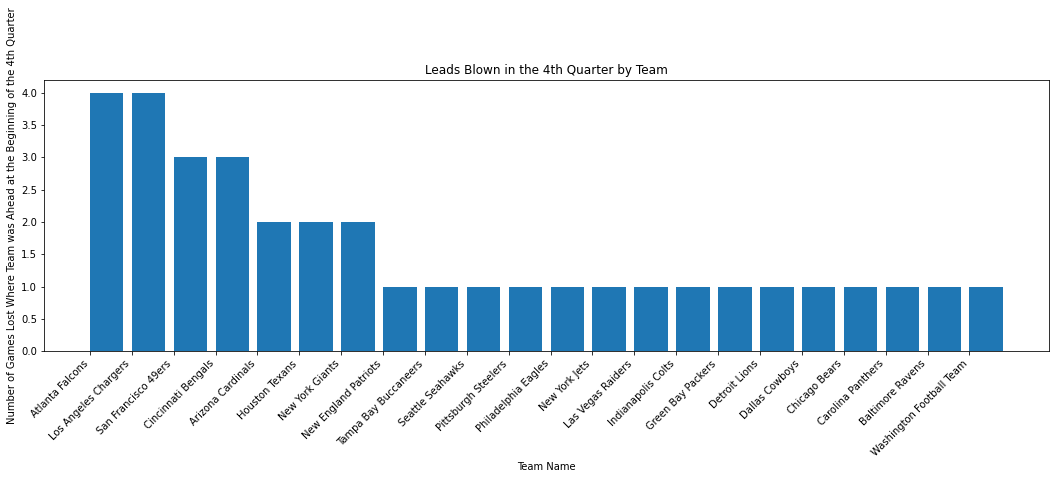

In [24]:
fig, ax = plt.subplots(figsize = (18,5));
ax.bar(x_vals, y_vals, align = 'edge');
ax.set(title = 'Leads Blown in the 4th Quarter by Team', 
      xlabel = 'Team Name', 
      ylabel = 'Number of Games Lost Where Team was Ahead at the Beginning of the 4th Quarter');
plt.xticks(rotation = 45, ha = 'right');

In [25]:
plt.savefig('Teams Who Lost After Leading into the 4th Quarter.png')

<Figure size 432x288 with 0 Axes>

## Pulling Pressure Situations

### Let's see how some receivers' performances vary in a "pressure situation" vs their avg season stats

Let's first pull our df from above and assign it to a new variable so we can analyze and manipulate the data without affecting the original data frame

In [26]:
close_clean = close_games_df[['Game ID', 'Home Team Name', 'Home Team Alias', 'Home Team Id', 
               'Away Team Name', 'Away Team Alias', 'Away Team Id', 
                'Final Score (Home)','Final Score (Away)', 'Game Diff (Final)',
                'Beg of the 4th Quarter Score (Home)', 
                'Beg of the 4th Quarter Score (Away)',
                'Game Diff (4th Quarter)',
                'Quarter 4 Points (Home)', 'Quarter 4 Points (Away)', 
                'Overtime Points (Home)', 'Overtime Points (Away)', 
               'Down Team Won?']]
close_clean

,Game ID,Home Team Name,Home Team Alias,Home Team Id,Away Team Name,Away Team Alias,Away Team Id,Final Score (Home),Final Score (Away),Game Diff (Final),Beg of the 4th Quarter Score (Home),Beg of the 4th Quarter Score (Away),Game Diff (4th Quarter),Quarter 4 Points (Home),Quarter 4 Points (Away),Overtime Points (Home),Overtime Points (Away),Down Team Won?
0,018556f9-1977-4a0b-8244-20cad15df9a4,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,Los Angeles Chargers,LAC,1f6dcffb-9823-43cd-9ff4-e7a8466749b5,13.0,16.0,-3.0,13.0,6.0,7.0,0.0,10.0,None,None,True
1,10339048-8c6b-43c7-ae7c-d68cf44417d3,Denver Broncos,DEN,ce92bd47-93d5-4fe9-ada4-0fc681e6caa0,Tennessee Titans,TEN,d26a1ca5-722d-4274-8f97-c92e49c96315,14.0,16.0,-2.0,7.0,7.0,0.0,7.0,9.0,None,None,False
2,213b8eda-43d8-4e62-9951-ed4c605fca0d,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,Green Bay Packers,GB,a20471b4-a8d9-40c7-95ad-90cc30e46932,34.0,43.0,-9.0,10.0,29.0,-19.0,24.0,14.0,None,None,False
3,24734cde-bf1b-46e5-ad50-d61e47aeca26,Jacksonville Jaguars,JAC,f7ddd7fa-0bae-4f90-bc8e-669e4d6cf2de,Indianapolis Colts,IND,82cf9565-6eb9-4f01-bdbd-5aa0d472fcd9,27.0,20.0,7.0,17.0,17.0,0.0,10.0,3.0,None,None,False
4,5a5b0a83-1765-4729-b914-73ff7d4c4c89,Carolina Panthers,CAR,f14bf5cc-9a82-4a38-bc15-d39f75ed5314,Las Vegas Raiders,LV,7d4fcc64-9cb5-4d1b-8e75-8a906d1e1576,30.0,34.0,-4.0,15.0,27.0,-12.0,15.0,7.0,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,7b9e1d03-4907-4a24-8f43-ef651804f3ff,Kansas City Chiefs,KC,6680d28d-d4d2-49f6-aace-5292d3ec02c2,Cleveland Browns,CLE,d5a2eb42-8065-4174-ab79-0a6fa820e35e,22.0,17.0,5.0,22.0,10.0,12.0,0.0,7.0,None,None,False
3,c4032aec-ffc3-4275-994d-19aba97c1bc4,New Orleans Saints,NO,0d855753-ea21-4953-89f9-0e20aff9eb73,Tampa Bay Buccaneers,TB,4254d319-1bc7-4f81-b4ab-b5e6f3402b69,20.0,30.0,-10.0,20.0,20.0,0.0,0.0,10.0,None,None,False
0,8328733a-b4b9-47b9-bd2e-b3a38a87442e,Green Bay Packers,GB,a20471b4-a8d9-40c7-95ad-90cc30e46932,Tampa Bay Buccaneers,TB,4254d319-1bc7-4f81-b4ab-b5e6f3402b69,26.0,31.0,-5.0,23.0,28.0,-5.0,3.0,3.0,None,None,False
1,cef80d79-ce26-434f-9f44-b560b66fa83e,Kansas City Chiefs,KC,6680d28d-d4d2-49f6-aace-5292d3ec02c2,Buffalo Bills,BUF,768c92aa-75ff-4a43-bcc0-f2798c2e1724,38.0,24.0,14.0,31.0,15.0,16.0,7.0,9.0,None,None,False


We want to look at situations where the game's final score was within 3 points or less to hone in on games where the score was close implying there would've been a lot more pressure on our offensive players of the team that was down to pick up some points and take the lead

In [27]:
close = close_clean[abs(close_clean['Game Diff (Final)'])<3]
close

,Game ID,Home Team Name,Home Team Alias,Home Team Id,Away Team Name,Away Team Alias,Away Team Id,Final Score (Home),Final Score (Away),Game Diff (Final),Beg of the 4th Quarter Score (Home),Beg of the 4th Quarter Score (Away),Game Diff (4th Quarter),Quarter 4 Points (Home),Quarter 4 Points (Away),Overtime Points (Home),Overtime Points (Away),Down Team Won?
1,10339048-8c6b-43c7-ae7c-d68cf44417d3,Denver Broncos,DEN,ce92bd47-93d5-4fe9-ada4-0fc681e6caa0,Tennessee Titans,TEN,d26a1ca5-722d-4274-8f97-c92e49c96315,14.0,16.0,-2.0,7.0,7.0,0.0,7.0,9.0,None,None,False
11,a76ed880-ef6c-43a3-b2a2-f6eae7f072b2,Dallas Cowboys,DAL,e627eec7-bbae-4fa4-8e73-8e1d6bc5c060,Atlanta Falcons,ATL,e6aa13a4-0055-48a9-bc41-be28dc106929,40.0,39.0,1.0,24.0,29.0,-5.0,16.0,10.0,NaN,NaN,True
2,4b48bcbc-a0f5-4e58-aa5f-0f57fc34c1d6,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,Tennessee Titans,TEN,d26a1ca5-722d-4274-8f97-c92e49c96315,30.0,31.0,-1.0,24.0,25.0,-1.0,6.0,6.0,NaN,NaN,False
4,664eab35-3dfe-491b-b98d-b4ebfe0c4906,Philadelphia Eagles,PHI,386bdbf9-9eea-4869-bb9a-274b0bc66e80,Cincinnati Bengals,CIN,ad4ae08f-d808-42d5-a1e6-e9bc4e34d123,23.0,23.0,0.0,16.0,17.0,-1.0,7.0,6.0,0,0,False
5,adcc4902-b1af-486a-838e-8ca23f72eebd,Chicago Bears,CHI,7b112545-38e6-483c-a55c-96cf6ee49cb8,Tampa Bay Buccaneers,TB,4254d319-1bc7-4f81-b4ab-b5e6f3402b69,20.0,19.0,1.0,14.0,16.0,-2.0,6.0,3.0,NaN,NaN,True
9,dc223e91-352a-4e06-b4bb-8d1f841ea7b7,Seattle Seahawks,SEA,3d08af9e-c767-4f88-a7dc-b920c6d2b4a8,Minnesota Vikings,MIN,33405046-04ee-4058-a950-d606f8c30852,27.0,26.0,1.0,21.0,19.0,2.0,6.0,7.0,NaN,NaN,False
2,354151c3-fded-48aa-8ade-cc49dff33efc,New York Giants,NYG,04aa1c9d-66da-489d-b16a-1dee3f2eec4d,Washington Football Team,WAS,22052ff7-c065-42ee-bc8f-c4691c50e624,20.0,19.0,1.0,13.0,10.0,3.0,7.0,9.0,NaN,NaN,False
13,f478f156-43d2-4b8e-af27-4e66b960a335,Philadelphia Eagles,PHI,386bdbf9-9eea-4869-bb9a-274b0bc66e80,Baltimore Ravens,BAL,ebd87119-b331-4469-9ea6-d51fe3ce2f1c,28.0,30.0,-2.0,6.0,24.0,-18.0,22.0,6.0,NaN,NaN,False
6,6b74b6c3-0208-4e22-9df5-0e52a14ff2e5,Philadelphia Eagles,PHI,386bdbf9-9eea-4869-bb9a-274b0bc66e80,New York Giants,NYG,04aa1c9d-66da-489d-b16a-1dee3f2eec4d,22.0,21.0,1.0,10.0,14.0,-4.0,12.0,7.0,NaN,NaN,True
12,eb40fc37-7841-4e32-a896-5299262c2c43,Atlanta Falcons,ATL,e6aa13a4-0055-48a9-bc41-be28dc106929,Detroit Lions,DET,c5a59daa-53a7-4de0-851f-fb12be893e9e,22.0,23.0,-1.0,14.0,13.0,1.0,8.0,10.0,NaN,NaN,True


Let's load in a list of top wide receivers provided my Michael with their player ids and team affiliation so we can pull their play by play stats for a game and compare this to their season average. We're also going to loop through these players to pull a game id from our "close" df to look at. This will be passed into a new df for the sake of not amending the original list of receivers

In [28]:
top_wr = pd.DataFrame({'Name': ['Davante Adams', 'Calvin Ridley', 'Adam Thielen', 'Mike Evans', 'Allen Robinson II', 
                               'Tyreek Hill', 'JuJu Smith-Schuster', 'Keenan Allen', 'D.K. Metcalf', 'Tyler Lockett',
                               'Stefon Diggs'],
                      'Player ID': ['e7d6ae25-bf15-4660-8b37-c37716551de3', '926e2674-52d6-4cec-9991-46ee85cc8cfd', 
                                    '2fa2b2da-4aa9-44b5-b27e-56876dfe2ad4', 'c48c21d9-0ae5-478c-ad34-30a660cfa9b8', 
                                   '0fd32417-8410-4a8f-8919-386c433bca43', '01d8aee3-e1c4-4988-970a-8c0c2d08bd83', 
                                   '9547fbb1-0d4f-4d9e-83b9-e2fa30463bb9', '5f424505-f29f-433c-b3f2-1a143a04a010',
                                   '754faf0f-40f7-45f0-b23b-6ce990ecaf26', 'dffa69ad-331e-4f09-ae38-40a5a4406be6',
                                   'a1c40664-b265-4083-aad2-54b4c734f2c5'],
                      'Player Team Alias': ['GB', 'ATL', 'MIN', 'TB', 'CHI', 'KC', 'PIT', 'LAC', 'SEA', 'SEA', 'BUF']})
top_and_close = pd.DataFrame({'Name':[],
                             'Player ID':[],
                             'Player Team Alias': [],
                             'Game ID':[]})
for i in range(len(top_wr['Player Team Alias'])):
    df = close[(close['Home Team Alias']==list(top_wr['Player Team Alias'])[i]) | (close['Away Team Alias']==list(top_wr['Player Team Alias'])[i])]
    if df.empty == False:
        top_and_close = top_and_close.append({'Name':list(top_wr['Name'])[i], 
                                              'Player ID':list(top_wr['Player ID'])[i], 
                                              'Player Team Alias': list(top_wr['Player Team Alias'])[i], 
                                              'Game ID':list(df['Game ID'])[0]}, ignore_index = True)

Let's return the df again to confirm that we successfully pulled a game for each receiver

In [29]:
top_and_close

,Name,Player ID,Player Team Alias,Game ID
0,Calvin Ridley,926e2674-52d6-4cec-9991-46ee85cc8cfd,ATL,a76ed880-ef6c-43a3-b2a2-f6eae7f072b2
1,Adam Thielen,2fa2b2da-4aa9-44b5-b27e-56876dfe2ad4,MIN,4b48bcbc-a0f5-4e58-aa5f-0f57fc34c1d6
2,Mike Evans,c48c21d9-0ae5-478c-ad34-30a660cfa9b8,TB,adcc4902-b1af-486a-838e-8ca23f72eebd
3,Allen Robinson II,0fd32417-8410-4a8f-8919-386c433bca43,CHI,adcc4902-b1af-486a-838e-8ca23f72eebd
4,Tyreek Hill,01d8aee3-e1c4-4988-970a-8c0c2d08bd83,KC,c5fa2cf5-6aca-4c12-b258-0d6b1b922b90
5,JuJu Smith-Schuster,9547fbb1-0d4f-4d9e-83b9-e2fa30463bb9,PIT,ffefae13-6fa5-4699-960f-0a7fd3c1265d
6,Keenan Allen,5f424505-f29f-433c-b3f2-1a143a04a010,LAC,a06990f4-c5bf-4b3b-9743-622dbdc0897d
7,D.K. Metcalf,754faf0f-40f7-45f0-b23b-6ce990ecaf26,SEA,dc223e91-352a-4e06-b4bb-8d1f841ea7b7
8,Tyler Lockett,dffa69ad-331e-4f09-ae38-40a5a4406be6,SEA,dc223e91-352a-4e06-b4bb-8d1f841ea7b7
9,Stefon Diggs,a1c40664-b265-4083-aad2-54b4c734f2c5,BUF,69192d97-c724-445f-8b9a-cf0d83f613b9


Now let's look at the data frame Michael built with the payer's season stats and print out the columns so we can identify 2/3 specific stats to analyze

In [30]:
wr_season_stats.columns

Index(['Player ID', 'Name', 'Position', 'Air Yards', 'Yards Per Reception',
       'Broken Tackles Receiving', 'Catchable Passes Dropped',
       'Total Dropped Passes', 'Longest Reception', 'Longest TD Reception',
       'Receptions', 'Redzone Targets', 'Targets', 'TD Receptions',
       'Reception Yards', 'Yards After Catch', 'Yards After Contact Receiving',
       'Scrambles', 'Rushing Attempts', 'Yards Per Rush',
       'Broken Tackles Rushing', 'Kneel Downs', 'Longest Rush',
       'Longest TD Run', 'Redzone Rushing Attempts', 'Negative Rushes',
       'Yards Lost Rushing', 'Rushing Touchdowns', 'Total Rushing Yards',
       'Yards After Contact Rushing', 'Fumbles', 'Fumbles Lost'],
      dtype='object')

We'll pull in Johnny's function built to pull a player's play by play stats  for a specific player and game and run a test request so we can see what kind of stats we're getting back and cross reference that with the stats available for the season stats data frame

In [31]:
test = get_pbp_stats('a76ed880-ef6c-43a3-b2a2-f6eae7f072b2', '926e2674-52d6-4cec-9991-46ee85cc8cfd')

In [32]:
test.columns

Index(['stat_type', 'attempt', 'yards', 'firstdown', 'inside_20', 'goaltogo',
       'broken_tackles', 'kneel_down', 'scramble', 'yards_after_contact',
       'tackle', 'missed_tackles', 'def_target', 'def_comp', 'blitz', 'hurry',
       'knockdown', 'batted_pass', 'category', 'complete', 'att_yards',
       'incompletion_type', 'pocket_time', 'on_target_throw', 'target',
       'dropped', 'catchable', 'touchdown', 'reception', 'yards_after_catch',
       'made', 'endzone', 'onside_attempt', 'onside_success', 'squib_kick',
       'return', 'ast_tackle', 'primary', 'qb_hit', 'down', 'tlost',
       'tlost_yards', 'penalty', 'missed', 'gross_yards', 'touchback',
       'pass_defended', 'sack', 'sack_yards', 'hang_time', 'nullified',
       'own_rec', 'player.id', 'player.name', 'player.jersey',
       'player.reference', 'player.position', 'player.sr_id', 'team.id',
       'team.name', 'team.market', 'team.alias', 'team.reference',
       'team.sr_id', 'player'],
      dtype='object')

In [33]:
test[['target','dropped', 'yards_after_catch']]

,target,dropped,yards_after_catch
4,1.0,0.0,NaN
52,1.0,0.0,2.0


In [34]:
wr_season_stats[wr_season_stats['Player ID']=='926e2674-52d6-4cec-9991-46ee85cc8cfd'][['Targets','Total Dropped Passes','Yards After Catch']]


,Targets,Total Dropped Passes,Yards After Catch
40,143.0,6.0,275.0


Looks like we have what we're looking for so now it's time to go in and create a new data frame and loop through our rows of top players and their player/game ids

In [35]:
comparison_df = pd.DataFrame({'Name':[],
                       'Player ID':[],
                       'Player Team Alias':[],
                       'Targets':[],
                      'Dropped': [],
                      'Yards After Catch': [],
                      'Targets Season Avg': [],
                      'Dropped Season Avg': [],
                      'Yards After Catch Avg': []})

for row in range(len(top_and_close)):
    player_id = list(top_and_close['Player ID'])[row]
    game_id = list(top_and_close['Game ID'])[row]
    pressure_stats = get_pbp_stats(game_id, player_id)[['target','dropped', 'yards_after_catch']]
    targets = pressure_stats['target'].sum()
    dropped = pressure_stats['dropped'].sum()
    yac = pressure_stats['yards_after_catch'].sum()
    season_stats = wr_season_stats[wr_season_stats['Player ID']==player_id][['Targets','Total Dropped Passes','Yards After Catch']]
    targets_avg = (list(season_stats['Targets'])[0])/68
    dropped_avg = (list(season_stats['Total Dropped Passes'])[0])/68
    yac_avg = (list(season_stats['Yards After Catch'])[0])/68
    comparison_df = comparison_df.append({'Name':list(top_and_close['Name'])[row],
                       'Player ID':list(top_and_close['Player ID'])[row],
                       'Player Team Alias': list(top_and_close['Player Team Alias'])[row],
                       'Targets':pressure_stats['target'].sum(),
                      'Dropped': pressure_stats['dropped'].sum(),
                      'Yards After Catch': yac,
                      'Targets Season Avg': targets_avg,
                      'Dropped Season Avg': dropped_avg,
                      'Yards After Catch Avg': yac_avg}, ignore_index = True)

In [36]:
comparison_df

,Name,Player ID,Player Team Alias,Targets,Dropped,Yards After Catch,Targets Season Avg,Dropped Season Avg,Yards After Catch Avg
0,Calvin Ridley,926e2674-52d6-4cec-9991-46ee85cc8cfd,ATL,2.0,0.0,2.0,2.102941,0.088235,4.044118
1,Adam Thielen,2fa2b2da-4aa9-44b5-b27e-56876dfe2ad4,MIN,2.0,0.0,3.0,1.588235,0.102941,3.573529
2,Mike Evans,c48c21d9-0ae5-478c-ad34-30a660cfa9b8,TB,2.0,0.0,0.0,1.602941,0.058824,3.897059
3,Allen Robinson II,0fd32417-8410-4a8f-8919-386c433bca43,CHI,4.0,0.0,5.0,2.220588,0.044118,4.691176
4,Tyreek Hill,01d8aee3-e1c4-4988-970a-8c0c2d08bd83,KC,4.0,0.0,0.0,1.985294,0.073529,6.382353
5,JuJu Smith-Schuster,9547fbb1-0d4f-4d9e-83b9-e2fa30463bb9,PIT,2.0,0.0,1.0,1.882353,0.044118,6.014706
6,Keenan Allen,5f424505-f29f-433c-b3f2-1a143a04a010,LAC,1.0,0.0,0.0,2.161765,0.044118,6.426471
7,D.K. Metcalf,754faf0f-40f7-45f0-b23b-6ce990ecaf26,SEA,7.0,0.0,11.0,1.897059,0.117647,5.338235
8,Tyler Lockett,dffa69ad-331e-4f09-ae38-40a5a4406be6,SEA,2.0,1.0,4.0,1.941176,0.117647,4.808824
9,Stefon Diggs,a1c40664-b265-4083-aad2-54b4c734f2c5,BUF,5.0,0.0,33.0,2.441176,0.117647,6.823529


Now we'll be creating a function to loop through the data we pulled and plot each players results into a scatter plot to show where their performance for that game compared to their seasonal averages. We'll then loop through that function so that we have a visualization for each player. This function will also save the images as png files to reference later

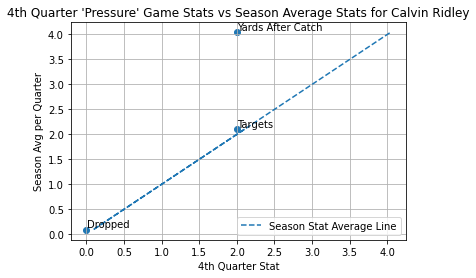

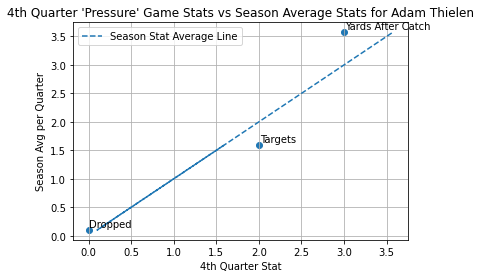

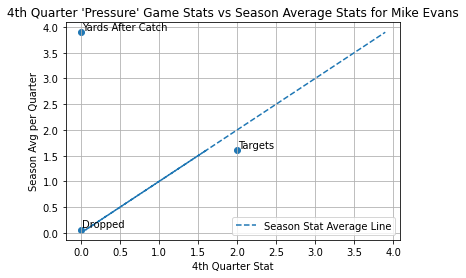

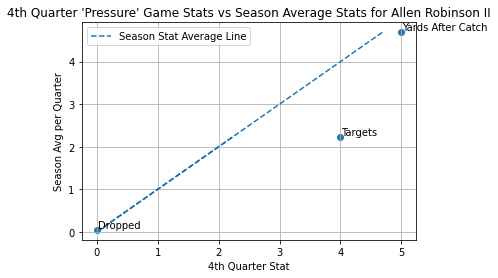

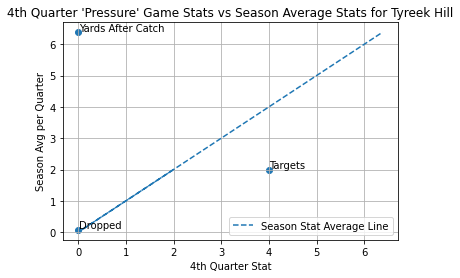

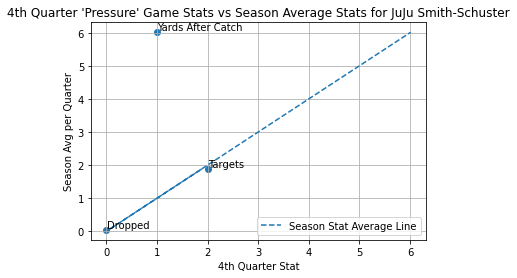

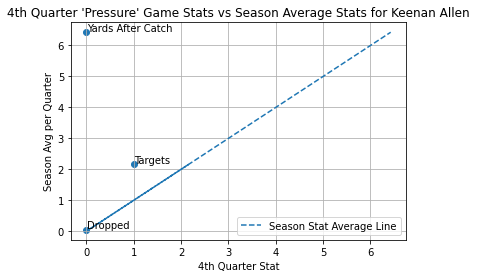

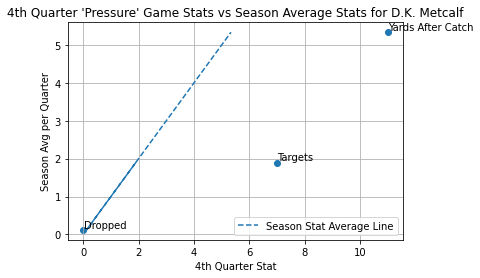

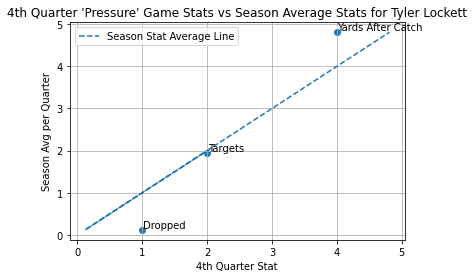

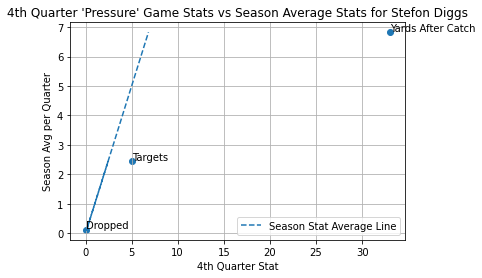

In [37]:
def plot_this_df(player_df):
    x_vals = [player_df['Targets'], player_df['Dropped'], player_df['Yards After Catch']]
    y_vals = [player_df['Targets Season Avg'],player_df['Dropped Season Avg'], player_df['Yards After Catch Avg']]
    annotations = ['Targets', 'Dropped', 'Yards After Catch']
    fig, ax = plt.subplots()
    ax.scatter(x_vals, y_vals)
    ax.set(title = f"4th Quarter 'Pressure' Game Stats vs Season Average Stats for {str(list(player_df['Name']))[2:-2]}",
          xlabel = "4th Quarter Stat",
          ylabel = "Season Avg per Quarter")
    ax.plot(y_vals, y_vals, linestyle = 'dashed', label = "Season Stat Average Line")
    ax.legend()
    for k, label in enumerate(annotations):
        plt.annotate(label, (x_vals[k]+0.01, y_vals[k]+0.05))
    ax.grid()
    plt.savefig(f"4th Quarter 'Pressure' Game Stats vs Season Average Stats for {str(list(player_df['Name']))[2:-2]}.png");

for i in range(len(comparison_df)):
    player_df = comparison_df[comparison_df['Name']==list(comparison_df['Name'])[i]]
    plot_this_df(player_df)

To break down what we're looking at, the line in each of the scatter plots show where the points would align if the player's game stats were pretty much on par with their season average stats. A few things to note:
- If the "Dropped" point is above the line, it means the player dropped less passes in this game's 4th Quarter (a pressure situation) than his season stats predicted he would drop. If it is below the line, it means the player dropped more passes in this game's 4th Quarter (pressure situation) than his season stats predicted he would drop.
- If the "Yards After Catch" point is above the line, it means the player ran less yards after the catch in this game's 4th Quarter (a pressure situation) than his season stats predicted he would run. If it is below the line, it means the player ran more yards after the catch in this game's 4th Quarter (pressure situation) than his season stats predicted he would run.
- If the "Targets" point is above the line, it means the player was a target less often in this game's 4th Quarter (a pressure situation) than his season stats predicted he would be. If it is below the line, it means the player was a target more often in this game's 4th Quarter (pressure situation) than his season stats predicted he would be.